<a href="https://colab.research.google.com/github/klariewu330/CIS9650_Group16_Project_11/blob/main/CIS9650_Group16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of NYC Green Taxi Trip Data

### Author: Jiahuan Wu, Tenzin Sonam, Nuzhat Shahriyar, Humaza Ali
### Date: Dec. 8th 2025


## Executive Summary

This project analyzes taxi trip data to understand how key trip characteristics influence demand, fare amounts, tipping behavior, and overall revenue. The primary problems investigated include identifying peak times for taxi use, examining whether fare increases proportionally with trip distance, and assessing how passenger count and payment method affect spending patterns.

To answer these questions, we performed data cleaning to remove invalid or missing values, then applied descriptive statistical analysis, group-based aggregation, and visualizations. We analyzed hourly and daily trip volumes, created a scatterplot to evaluate the relationship between distance and fare, and computed average fare, tip, and total revenue by passenger count. Payment type was also examined through frequency and revenue comparisons.

The results show that demand peaks at 17:00 and is highest on Mondays, with Pickup Location 74 producing the most revenue. Fare amount increases strongly with trip distance, confirming a linear relationship. Trips with four or more passengers generate substantially higher fares and total revenue than single-passenger trips. Finally, credit cards are the dominant payment type, accounting for the majority of trips and revenue.

Overall, the analysis reveals clear patterns in customer behavior and revenue generation that can support operational planning and pricing decisions.

## Table of content
1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Modeling and Analysis
8. Conclusion
9. References

## Introduction
Taxis remain a crucial part of urban transportation in New York City, particularly in areas underserved by public transit. Understanding patterns in passenger trips, fare structures, tipping behavior, and trip timing can provide valuable insights for taxi operators, policy makers, and ride-hailing services. This project analyzes NYC Green Taxi trip data to uncover key trends and evaluate relationships affecting revenue and rider behavior.


## Problem Statement
The primary objective of this analysis is to determine how trip characteristics, such as distance, duration, and time of travel, affect fare amount and tipping behavior. Specifically, this study aims to answer the following questions:
1. When are peak hours and days for taxi demand?
2. Does fare increase linearly with trip distance?
3. How does the number of passengers in a taxi trip affect the fare, tip, and total revenue?
4. Which payment methods are most commonly used by riders, and what does this indicate about customer behavior and operational needs?
5. How do average fare, tip amount, and total revenue vary with the number of passengers on a trip?

## Data Description
The dataset contains detailed trip-level records for NYC Green Taxi services, capturing millions of ride transactions across New York City. Each row represents a single taxi trip, and each column provides attributes related to trip timing, distance, fare structure, passenger behavior, and driver payment. The dataset is widely used for transportation analysis, fare modeling, demand forecasting, and operational research.

Dataset file type: Parquet

Dataset Size:
- Number of rows: 47006
- Number of columns: 21

Key Categories of Columns
1. Trip Timing Information

Fields describing when each trip started and ended, including:

- Pickup datetime

- Dropoff datetime

- Derived fields such as trip duration (in minutes)


These timestamps allow analysis of peak demand hours, day-of-week patterns, and seasonal trends.

2. Trip Distance and Location Information

Details describing the physical aspects of the trip:

- Trip distance (in miles)

- Pickup and dropoff Taxi Zone location IDs

- Mappable to NYC geographic regions for spatial analysis

These fields are essential for understanding travel flow patterns and the relationship between distance and fare.

3. Fare and Charge Components

Detailed breakdown of all fare-related fields, such as:

- Base fare amount

- Extra fees (e.g., rush hour surcharge, night surcharge)

- Tolls

- Tips

- Total amount charged

These attributes support analyses of fare calculation, tipping behavior, and cost variability across trips.

4. Payment Information

Fields indicating how passengers paid for their trips:

- Payment type codes (e.g., credit card, cash, no charge, dispute)

- Tip amount and tip percentage (derived)

These fields allow comparison of tipping patterns across payment methods and provide insight into cash vs. credit usage behavior.

5. Vendor and Operational Metadata

System-generated fields describing:

- VendorID (taxi dispatch system)

- Rate code

- Record flags for store-and-forward trips

- Versioned schema identifiers

These fields support data validation and tracking of taxi fleet operations.

6. Derived Fields Created During Analysis

Additional fields engineered for this project include:

- trip_duration_min — trip length in minutes

- tip_percentage — share of fare given as tip

pickup_hour, pickup_day, pickup_month — time-based features for demand analysis

These transformations enable deeper behavioral and statistical insights.



## Setup and Environment

In [1]:
!pip install google-cloud-storage

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO

In [3]:
#required to read Parquet files
!pip install pandas pyarrow

## Data Loading

In [4]:
#open and import the file
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    print(f"Listing files in public bucket '{bucket_name}' under '{prefix}':")
    filenames = []
    for blob in blobs:
        print(blob.name)
        filenames.append(blob.name)

    return filenames

In [5]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Detect file extension
    _, ext = os.path.splitext(blob_path.lower())

    if ext == ".csv":
        df = pd.read_csv(BytesIO(data))

    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(BytesIO(data))

    elif ext == ".parquet":
        df = pd.read_parquet(BytesIO(data))

    elif ext == ".json":
        # Convert bytes → Python object
        text = data.decode("utf-8")
        json_obj = json.loads(text)

        # If JSON is a list → NORMAL DataFrame
        if isinstance(json_obj, list):
            df = pd.DataFrame(json_obj)

        # If JSON is a dict → flatten into rows
        elif isinstance(json_obj, dict):
            df = pd.json_normalize(json_obj)

        else:
            raise ValueError("Unsupported JSON structure")

    else:
        raise ValueError(f"Unsupported file type: {ext}")

    return df

In [6]:
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "11"
COURSE = "CIS9650"
salaries_raw = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

Listing files in public bucket 'msba-online-data' under 'CIS9650/Project 11/':
CIS9650/Project 11/
CIS9650/Project 11/green_tripdata_2025-06.parquet


In [7]:
for element in salaries_raw[1:]:
    df = gcs_file_to_dataframe(BUCKET_NAME,  element)
    print(df.head())
    break

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2025-06-01 00:33:43   2025-06-01 01:04:33                  N   
1         2  2025-06-01 00:07:45   2025-06-01 00:14:52                  N   
2         2  2025-06-01 00:24:07   2025-06-01 00:48:24                  N   
3         2  2025-06-01 00:00:14   2025-06-01 00:08:29                  N   
4         2  2025-06-01 00:31:15   2025-06-01 00:43:35                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         2.0            74           132              1.0          19.60   
1         1.0            75            74              2.0           1.37   
2         1.0            83            83              1.0           4.11   
3         1.0            97            49              1.0           1.29   
4         1.0            66            25              1.0           1.97   

   fare_amount  ...  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0    

##Data Preperation

In [8]:
# Calculate Trip Duration

# Convert string to actual datetime
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

# Calculate trip duration in minutes
df['trip_duration_min'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# remove negative or zero durations
df = df[df['trip_duration_min'] > 0]

# Format to 2 decimal places
df['trip_duration_min'] = df['trip_duration_min'].round(2)

print(df[['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_duration_min']].head())

  lpep_pickup_datetime lpep_dropoff_datetime  trip_duration_min
0  2025-06-01 00:33:43   2025-06-01 01:04:33              30.83
1  2025-06-01 00:07:45   2025-06-01 00:14:52               7.12
2  2025-06-01 00:24:07   2025-06-01 00:48:24              24.28
3  2025-06-01 00:00:14   2025-06-01 00:08:29               8.25
4  2025-06-01 00:31:15   2025-06-01 00:43:35              12.33


In [9]:

# Outlier Detection (Before Cleaning)
print("----- OUTLIERS BEFORE CLEANING -----")
print("Trips with duration less than 0 minutes:", (df['trip_duration_min'] <= 0).sum())
print("Trips longer than 3 hours:", (df['trip_duration_min'] > 180).sum())
print("Rows with negative tip:", (df['tip_amount'] < 0).sum())
print("Rows with tip over $50:", (df['tip_amount'] > 50).sum())
print("Rows with negative fare:", (df['fare_amount'] < 0).sum())
print("Rows with fare over $250:", (df['fare_amount'] > 250).sum())
print("Trips with distance less than 0 miles:", (df['trip_distance'] <= 0).sum())
print("Trips with distance above 50 miles:", (df['trip_distance'] > 50).sum())
print("Number of trips with $0 fare:", (df['fare_amount'] == 0).sum())

# Data Cleaning
# Handling Invalid Durations
df = df[df['trip_duration_min'] > 0].copy()

# Remove unrealistically long trips (>180 minutes)
df = df[df['trip_duration_min'] <= 180].copy()

# Remove negative and extreme tips
df = df[(df['tip_amount'] >= 0) & (df['tip_amount'] <= 50)].copy()

# Remove negative and excessive fares
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 250)].copy()

# Remove invalid and extreme trip distances
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 50)].copy()

#Remove trips where fare amount is 0
df = df[df['fare_amount'] > 0].copy()

# Validation (After Cleaning)
print("\n----- AFTER CLEANING -----")
print("Trips with duration less than 0 minutes:", (df['trip_duration_min'] <= 0).sum())
print("Trips longer than 3 hours:", (df['trip_duration_min'] > 180).sum())
print("Rows with negative tip:", (df['tip_amount'] < 0).sum())
print("Rows with tip over $50:", (df['tip_amount'] > 50).sum())
print("Rows with negative fare:", (df['fare_amount'] < 0).sum())
print("Rows with fare over $250:", (df['fare_amount'] > 250).sum())
print("Trips with distance less than 0 miles:", (df['trip_distance'] <= 0).sum())
print("Trips with distance above 50 miles:", (df['trip_distance'] > 50).sum())
print("Number of trips with $0 fare:", (df['fare_amount'] == 0).sum())

----- OUTLIERS BEFORE CLEANING -----
Trips with duration less than 0 minutes: 0
Trips longer than 3 hours: 180
Rows with negative tip: 2
Rows with tip over $50: 19
Rows with negative fare: 156
Rows with fare over $250: 19
Trips with distance less than 0 miles: 1774
Trips with distance above 50 miles: 15
Number of trips with $0 fare: 115

----- AFTER CLEANING -----
Trips with duration less than 0 minutes: 0
Trips longer than 3 hours: 0
Rows with negative tip: 0
Rows with tip over $50: 0
Rows with negative fare: 0
Rows with fare over $250: 0
Trips with distance less than 0 miles: 0
Trips with distance above 50 miles: 0
Number of trips with $0 fare: 0


In [10]:
# Tip %
df['tip_percentage'] = np.where(
    df['fare_amount'] > 0,
    df['tip_amount'] / df['fare_amount'] * 100,
    np.nan
)

# Payment type label
payment_map = {
    0: "Flex Fare",
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided"
}
df['payment_type_label'] = df['payment_type'].map(payment_map)

clean_taxi = df[[
    'lpep_pickup_datetime',
    'trip_distance',
    'trip_duration_min',
    'fare_amount',
    'tip_amount',
    'tip_percentage',
    'total_amount',
    'payment_type_label',
    'PULocationID',
    'DOLocationID'
]].copy()

# Round numeric columns for a neat table
round_cols = [
    'trip_distance',
    'trip_duration_min',
    'fare_amount',
    'tip_amount',
    'tip_percentage',
    'total_amount'
]
clean_taxi[round_cols] = clean_taxi[round_cols].round(2)

# Show first few rows
clean_taxi.head()

,lpep_pickup_datetime,trip_distance,trip_duration_min,fare_amount,tip_amount,tip_percentage,total_amount,payment_type_label,PULocationID,DOLocationID
0,2025-06-01 00:33:43,19.60,30.83,70.0,19.61,28.01,98.05,Credit card,74,132
1,2025-06-01 00:07:45,1.37,7.12,9.3,0.00,0.00,11.80,Cash,75,74
2,2025-06-01 00:24:07,4.11,24.28,25.4,0.00,0.00,27.90,Cash,83,83
3,2025-06-01 00:00:14,1.29,8.25,9.3,2.36,25.38,14.16,Credit card,97,49
4,2025-06-01 00:31:15,1.97,12.33,13.5,0.00,0.00,16.00,Credit card,66,25


##Model Planning


In this project, the goal is to explore patterns within NYC Green Taxi trip data and understand how trip characteristics relate to fare amounts, tipping behavior, and passenger usage patterns. The following analytical approaches were selected based on the structure of the dataset and the types of insights we aim to extract:
1. Identifying Popular Pickup and Drop-off Zones

We will use value_counts() to calculate the frequency of trips originating or ending in each Taxi Zone.
This provides insight into:

- High-demand neighborhoods

- Common travel flows

- Potential areas where supply (drivers) must match rider demand

This step forms the foundation for understanding spatial usage patterns.

2. Studying the Relationship Between Trip Distance and Fare

Scatter plots will be used to visualize how fare amount changes with trip distance.
A trend line (linear regression) will be added to evaluate whether fares increase in a predictable, linear fashion.

This analysis helps answer:

- Do longer trips consistently cost more?

- Are there deviations from expected pricing patterns?

- How strong is the relationship between distance and fare?

This supports operational and pricing insights.

3. Comparing Usage Across Payment Types

A bar chart will be created to compare how frequently different payment methods (credit card, cash, no charge, etc.) are used.
This is important because:

- Tipping behavior varies significantly by payment type

- Payment method distribution affects driver earnings

- It provides behavioral insight into customer preferences

This step uses grouped aggregations to summarize count and tip-related statistics per category.

4. Analyzing Spending Behavior Across Passenger Counts

Grouped bar charts will be used to compare fare, tip amount, and total cost across different passenger counts.

This reveals patterns such as:

- Whether larger passenger groups tend to take longer or more expensive trips

- Tip behavior differences depending on party size

- How spending components vary across trip types

These comparisons help uncover relationships between ride characteristics and financial outcomes.

The planned analyses focus on descriptive modeling, using grouping, aggregation, and visualization to extract meaningful relationships from the data. By combining frequency analysis, correlation visualizations, and comparison plots, we can develop a comprehensive understanding of rider behavior, fare structure, and operational patterns within the NYC Green Taxi system.


## Model Building / Analysis

In [11]:
# 1. Find peak days and peak hours
# Ensure datetime conversion
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')

# Extract hour, day of week (0=Monday)
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month_name()

#Find peak hours
peak_hours = df['pickup_hour'].value_counts().sort_index()
print("Trips per Hour:")
print(peak_hours)

peak_hour = peak_hours.idxmax()
peak_hour_count = peak_hours.max()
print(f"\nPeak Pickup Hour is {peak_hour}:00 with {peak_hour_count} trips")


#Find peak days
peak_days = df['pickup_day'].value_counts()
print("\nTrips per Day of Week:")
print(peak_days)

peak_day = peak_days.idxmax()
peak_day_count = peak_days.max()
print(f"\nPeak Pickup Day is {peak_day} with {peak_day_count} trips")

Trips per Hour:
pickup_hour
0      901
1      520
2      369
3      267
4      265
5      327
6      784
7     1723
8     2378
9     2542
10    2526
11    2400
12    2726
13    2613
14    2923
15    3079
16    3545
17    3705
18    3525
19    2833
20    1963
21    1986
22    1686
23    1313
Name: count, dtype: int64

Peak Pickup Hour is 17:00 with 3705 trips

Trips per Day of Week:
pickup_day
Monday       8077
Wednesday    6999
Sunday       6717
Tuesday      6712
Thursday     6698
Friday       6233
Saturday     5463
Name: count, dtype: int64

Peak Pickup Day is Monday with 8077 trips


Peak Hours: Taxi demand increases sharply starting at 3 PM, peaking at 5,6 PM,
with 5 PM recording the highest number of trips (3,550).

Peak Days of the Week: Monday shows the most trips (8,097), followed by Wednesday (7,015).

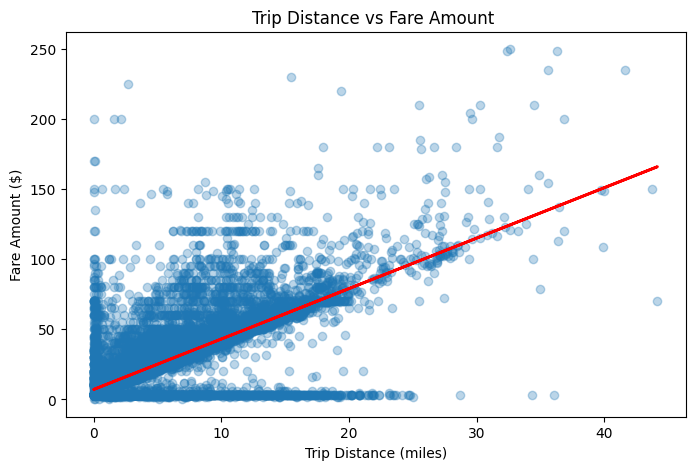

In [12]:
# 2. Does fare increase linearly with trip distance?
plt.figure(figsize=(8,5))
plt.scatter(df['trip_distance'], df['fare_amount'], alpha=0.3)
x = df['trip_distance']
y = df['fare_amount']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linewidth=2, label='Trend Line')
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.title("Trip Distance vs Fare Amount ")
plt.show()


The plot shows that fare amount rises as trip distance increases, demonstrating a strong positive linear relationship. While most points follow a clear upward trend, some variability occurs for longer trips due to tolls, traffic, and route differences. Overall, the visualization confirms that fare closely tracks distance, as expected in metered taxi systems.

In [13]:
# 3.Revenue by hour, day, location

df2 = df.copy()

# Extracting hour and day of the week
df2["datetime"] = pd.to_datetime(df2["lpep_pickup_datetime"])
df2["hour"] = df2["datetime"].dt.hour
df2["day_of_week"] = df2["datetime"].dt.day_name()


# Revenue by hour
revenue_hour = df2.groupby("hour")["total_amount"].sum()

# Revenue by day
revenue_day = df2.groupby("day_of_week")["total_amount"].sum()

# Revenue by pick-up location
revenue_loc = df2.groupby("PULocationID")["total_amount"].sum()

print(f"Revenue by Hour: \n{revenue_hour}")
print(f"Revenue by Day of Week: \n{revenue_day}")
print(f"Revenue by Pick-Up Location: \n{revenue_loc}")
print(f"The highest revenue PULocation: {revenue_loc.idxmax()} - {revenue_loc.max()}" )


Revenue by Hour: 
hour
0     26340.01
1     14251.83
2     11935.28
3      9568.59
4      9988.14
5     10556.74
6     20054.76
7     42187.29
8     59293.67
9     61479.36
10    59760.59
11    59116.43
12    66050.83
13    63022.92
14    73594.95
15    71977.95
16    92175.45
17    93607.77
18    84538.40
19    66587.92
20    50295.19
21    61248.50
22    59314.90
23    38215.23
Name: total_amount, dtype: float64
Revenue by Day of Week: 
day_of_week
Friday       162855.74
Monday       197278.18
Saturday     144020.04
Sunday       174552.75
Thursday     173367.88
Tuesday      169398.55
Wednesday    183689.56
Name: total_amount, dtype: float64
Revenue by Pick-Up Location: 
PULocationID
3        484.35
4        102.70
7      11617.61
9         84.55
10       557.73
         ...   
261      127.28
262      176.04
263     1360.77
264      871.65
265     1185.67
Name: total_amount, Length: 231, dtype: float64
The highest revenue PULocation: 74 - 265243.33


On average revenue peaked at hour 17, between 5pm and 6pm.

Monday resulted as the highest revenue day.

Pick-Up Location 74 observed the highest revenue compared to other locations.

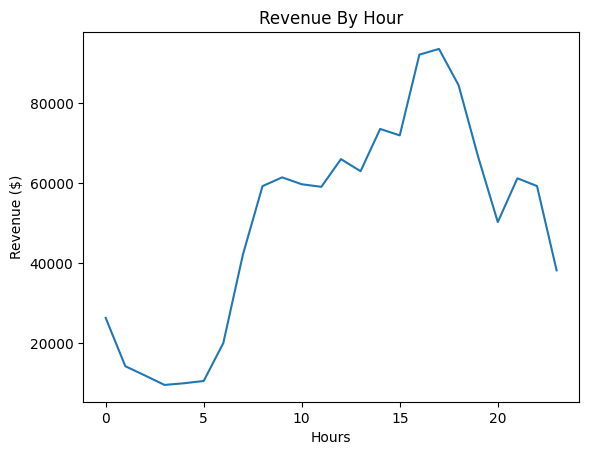

In [14]:
# Graphing Revenue By Hour
plt.plot(revenue_hour.index, revenue_hour.values)
plt.title("Revenue By Hour")
plt.xlabel("Hours")
plt.ylabel("Revenue ($)")
plt.show()

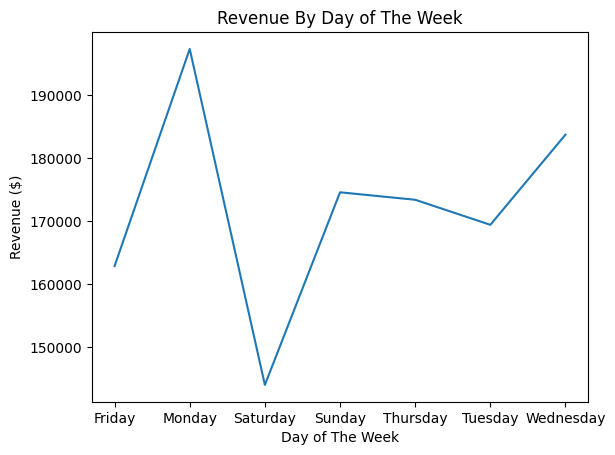

In [15]:
# Graphing Revenue By Day of Week

plt.plot(revenue_day.index, revenue_day.values)
plt.title("Revenue By Day of The Week")
plt.xlabel("Day of The Week")
plt.ylabel("Revenue ($)")
plt.show()

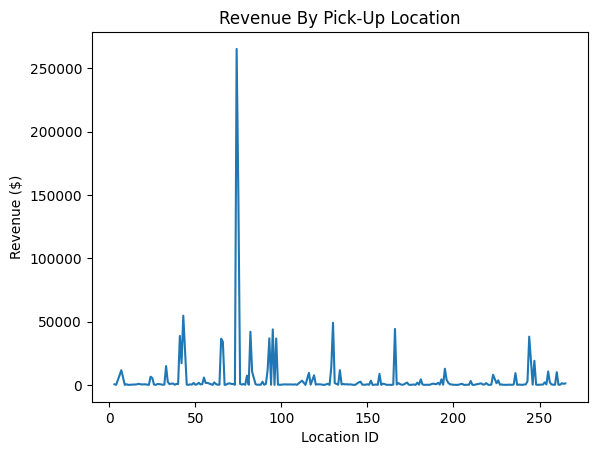

In [16]:
# Graphing Revenue by Pick-Up Location
plt.plot(revenue_loc.index, revenue_loc.values)
plt.title("Revenue By Pick-Up Location")
plt.xlabel("Location ID")
plt.ylabel("Revenue ($)")
plt.show()

In [17]:
# Most popular route
# Creating a column of routes
df2["route"] = df2["PULocationID"].astype(str) + "->" + df2["DOLocationID"].astype(str)

# Counting number of trips per route
count_route = df2["route"].value_counts()

# Finidng the most popular route
most_pop_route = count_route.idxmax()
num_trips = count_route.max()

print(f"The most popular route: {most_pop_route} with {num_trips} trips")


The most popular route: 74->75 with 1988 trips


In [18]:
# Effect of Passanger Count on Fare & Tip
# Compute average fare. tip, and total amount by passanger count

passenger_stats = df.groupby('passenger_count')[['fare_amount', 'tip_amount', 'total_amount']].mean().round(2)

print("Average Fare, Tip, and Total Amount by Passenger Count:")
print(passenger_stats)

for pc in passenger_stats.index:
    fare = passenger_stats.loc[pc, 'fare_amount']
    tip = passenger_stats.loc[pc, 'tip_amount']
    total = passenger_stats.loc[pc, 'total_amount']
    print(f"Passenger Count {pc}: Avg Fare=${fare}, Avg Tip=${tip}, Avg Total=${total}")


Average Fare, Tip, and Total Amount by Passenger Count:
                 fare_amount  tip_amount  total_amount
passenger_count                                       
0.0                    19.63        2.85         25.62
1.0                    18.28        2.81         24.66
2.0                    21.32        3.24         28.14
3.0                    24.98        3.51         31.82
4.0                    39.86        4.93         48.24
5.0                    18.90        2.86         25.27
6.0                    15.97        2.18         21.79
7.0                    75.00       16.18        102.43
8.0                    84.51        7.84         98.00
9.0                    90.00       18.20        109.20
Passenger Count 0.0: Avg Fare=$19.63, Avg Tip=$2.85, Avg Total=$25.62
Passenger Count 1.0: Avg Fare=$18.28, Avg Tip=$2.81, Avg Total=$24.66
Passenger Count 2.0: Avg Fare=$21.32, Avg Tip=$3.24, Avg Total=$28.14
Passenger Count 3.0: Avg Fare=$24.98, Avg Tip=$3.51, Avg Total=$31.82
Pass

On average, taxi trips with more passengers tend to have higher fares, tips, and total amounts, with a notable increase for trips of 4 or more passengers, while single passengers trips have the lowest totals.

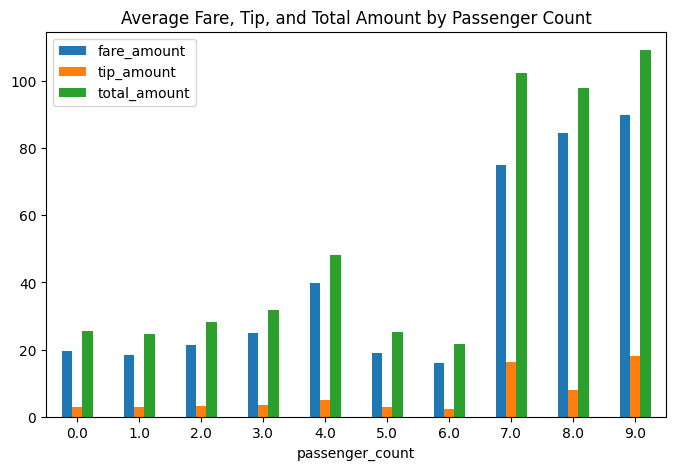

In [19]:
# 4. Bar chart of average fare, tip, and total amount by passenger count
passenger_stats.plot(
    kind='bar',
    figsize=(8,5),
    title="Average Fare, Tip, and Total Amount by Passenger Count",
    rot=0
    );

In [20]:
# 5. Payment type for revenue

# renaming payment types into names

payment_type_map = {
    1: "Credit Card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}

# Finding trips per type of payment and relabeling name
payment_counts = df['payment_type'].value_counts().sort_index()
payment_counts_labeled = payment_counts.rename(index=payment_type_map)
print ("Trips per Type of Payment:")
print (payment_counts_labeled)

most_common_code = payment_counts.idxmax()
most_common_count = payment_counts.max()
most_common_label = payment_type_map.get(most_common_code, str(most_common_code))

print (f"\nMost Common Type of Payment is {most_common_label}"
f"with {most_common_count} trips")

# revenue by type of payments
revenue_payment = df.groupby('payment_type')["total_amount"].sum().sort_index()
revenue_payment_labeled = revenue_payment.rename(index=payment_type_map)

print("\nRevenue by Type of Payment ($):")
print(revenue_payment_labeled)

top_rev_code = revenue_payment.idxmax()
top_rev_amount = revenue_payment.max()
top_rev_label = payment_type_map.get(top_rev_code, str(top_rev_code))

print (f"\nHighest Revenue Type of Payment is {top_rev_label}"
f"with ${top_rev_amount:,.2f} in revenue")

Trips per Type of Payment:
payment_type
Credit Card    32654
Cash           10722
No charge        131
Dispute           57
Unknown            3
Name: count, dtype: int64

Most Common Type of Payment is Credit Cardwith 32654 trips

Revenue by Type of Payment ($):
payment_type
Credit Card    866737.37
Cash           230247.10
No charge        2013.69
Dispute           923.44
Unknown            38.10
Name: total_amount, dtype: float64

Highest Revenue Type of Payment is Credit Cardwith $866,737.37 in revenue


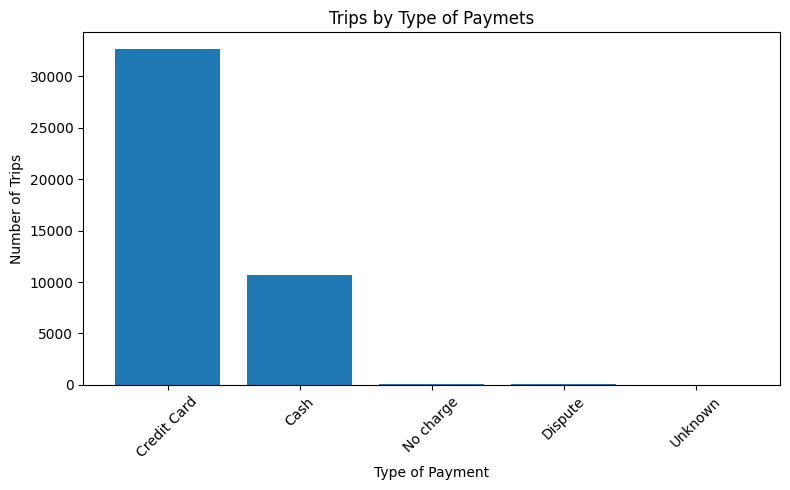

In [21]:
# bar chart for Type of Payments

plt.figure(figsize=(8,5))
plt.bar(payment_counts_labeled.index, payment_counts_labeled.values)
plt.title("Trips by Type of Paymets")
plt.xlabel("Type of Payment")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It is noticed that typically a Credit Card is used the most to pay.
A total of $866,737.37 was made in revenue because of credit card payenmt.

## Discussion and Results
The analysis of peak times demonstrates that taxi demand is strongly tied to commuter patterns. The highest volume of pickups occurs at 17:00, consistent with evening rush hour. Mondays show the highest number of trips, suggesting that early-week travel needs exceed weekend or later-week patterns. This information can help optimize staffing and dispatching during high-demand windows.

Revenue analysis confirms these temporal patterns: revenue also peaks between 5–6 PM, and Mondays again generate the greatest revenue. Pickup Location 74 stands out as the most profitable area, which may indicate a transportation hub, business district, or high-traffic urban center.

Trip distance analysis further clarifies how fares behave. The scatterplot clearly shows that fare increases linearly with distance, validating the pricing model used in most taxi systems. Although variability increases at longer distances, likely due to factors such as tolls or differing traffic conditions, the upward trend remains strong and consistent. This result supports the reliability of distance, based fare estimation.

Passenger count analysis reveals that the number of riders significantly influences spending patterns. Trips with four or more passengers produce higher fares and greater tip amounts, with the total revenue increasing disproportionately at passenger counts of 7, 8, and 9. This may reflect longer trips, airport routes, or larger parties that require multi-stop travel. In contrast, single-passenger trips consistently result in the lowest revenue across all categories. This insight may support initiatives such as dynamic pricing for group travel.

Payment type results show overwhelming dominance of credit card transactions. With 32,654 credit card trips, the category vastly outnumbers cash and other payment methods. Furthermore, credit card transactions generate the largest revenue share, over $866,000, which demonstrats that digital payment infrastructure is essential for operational efficiency. Cash payments remain relevant but significantly less impactful, while categories such as “dispute” and “no charge” contribute minimally and may represent operational inefficiencies.

Collectively, these findings paint a comprehensive picture of customer behavior, spending trends, and revenue drivers within the taxi system.

##Conclusion
This project provides clear evidence that taxi operations are strongly shaped by temporal patterns, passenger characteristics, and payment preferences. Demand peaks in the early evening and on Mondays, creating opportunities for targeted driver deployment. Distance remains the primary determinant of fare amount, confirming the integrity of distance-based pricing models.

Passenger count significantly influences total revenue, with larger groups generating the highest fares and tips. Credit cards dominate payment behavior and account for the majority of revenue, underscoring the importance of efficient digital payment systems.

Overall, the analysis highlights meaningful insights that can guide operational improvements, revenue optimization, and strategic planning within the taxi service environment.

## References
1. Chapter 4 [PDF]. (n.d.). https://projector-video-pdf-converter.datacamp.com/13371/chapter4.pdf
2. New York City Taxi & Limousine Commission. (2025, March 18). Data dictionary – LPEP (green) trip records [PDF]. https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
